In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "batch"
cell_type_key = 'celltype'
target_conditions = ["Batch8", "Batch9"]

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/toy/toy_count.h5ad")
adata

AnnData object with n_obs × n_vars = 36000 × 5000 
    obs: 'batch', 'celltype'

In [6]:
adata.X.min(), adata.X.max()

(0.0, 2117.0)

## Number of cells in each batch

In [7]:
adata.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Batch7    4000
Batch6    4000
Batch5    4000
Batch4    4000
Batch3    4000
Batch2    4000
Batch1    4000
Name: batch, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 28000 × 5000 
    obs: 'batch', 'celltype'

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 8000 × 5000 
    obs: 'batch', 'celltype'

In [10]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

Trying to set attribute `.obs` of view, making a copy.


In [11]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


In [13]:
adata_for_training.X.min(), adata_for_training.X.max()

(0.0, 7.2874913)

In [14]:
adata_out_of_sample.X.min(), adata_out_of_sample.X.max()

(0.0, 7.1323576)

## Train/Test Split

In [15]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [16]:
train_adata.shape, valid_adata.shape

((23800, 2000), (4200, 2000))

In [17]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [18]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=3.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/convergence/Toy_count/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2007)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1027584     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [19]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

## Training the network

In [20]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=32, 
              early_stop_limit=20,
              lr_reducer=15, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 23800 samples, validate on 4200 samples
Epoch 1/1000
 - 7s - loss: 2.1958 - nb: 2.1958 - val_loss: 2.0703 - val_nb: 2.0703
Epoch 2/1000
 - 5s - loss: 2.0754 - nb: 2.0754 - val_loss: 2.0441 - val_nb: 2.0441
Epoch 3/1000
 - 5s - loss: 2.0596 - nb: 2.0596 - val_loss: 2.0345 - val_nb: 2.0345
Epoch 4/1000
 - 5s - loss: 2.0502 - nb: 2.0502 - val_loss: 2.0328 - val_nb: 2.0328
Epoch 5/1000
 - 5s - loss: 2.0433 - nb: 2.0433 - val_loss: 2.0275 - val_nb: 2.0275
Epoch 6/1000
 - 5s - loss: 2.0380 - nb: 2.0380 - val_loss: 2.0250 - val_nb: 2.0250
Epoch 7/1000
 - 5s - loss: 2.0329 - nb: 2.0329 - val_loss: 2.0204 - val_nb: 2.0204
Epoch 8/1000
 - 5s - loss: 2.0283 - nb: 2.0283 - val_loss: 2.0186 - val_nb: 2.0186
Epoch 9/1000
 - 5s - loss: 2.0251 - nb: 2.0251 - val_loss: 2.0168 - val_nb: 2.0168
Epoch 10/1000
 - 5s - loss: 2.0231 - nb: 2.0231 - val_loss: 2.0160 - val_nb: 2.0160
Epoch 11/1000
 - 5s - loss: 2.0217 - nb: 2.0217 - val_loss: 2.0159 - val

In [21]:
network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

In [22]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [23]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 23800 × 10 
    obs: 'batch', 'celltype', 'n_counts', 'size_factors'

In [24]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


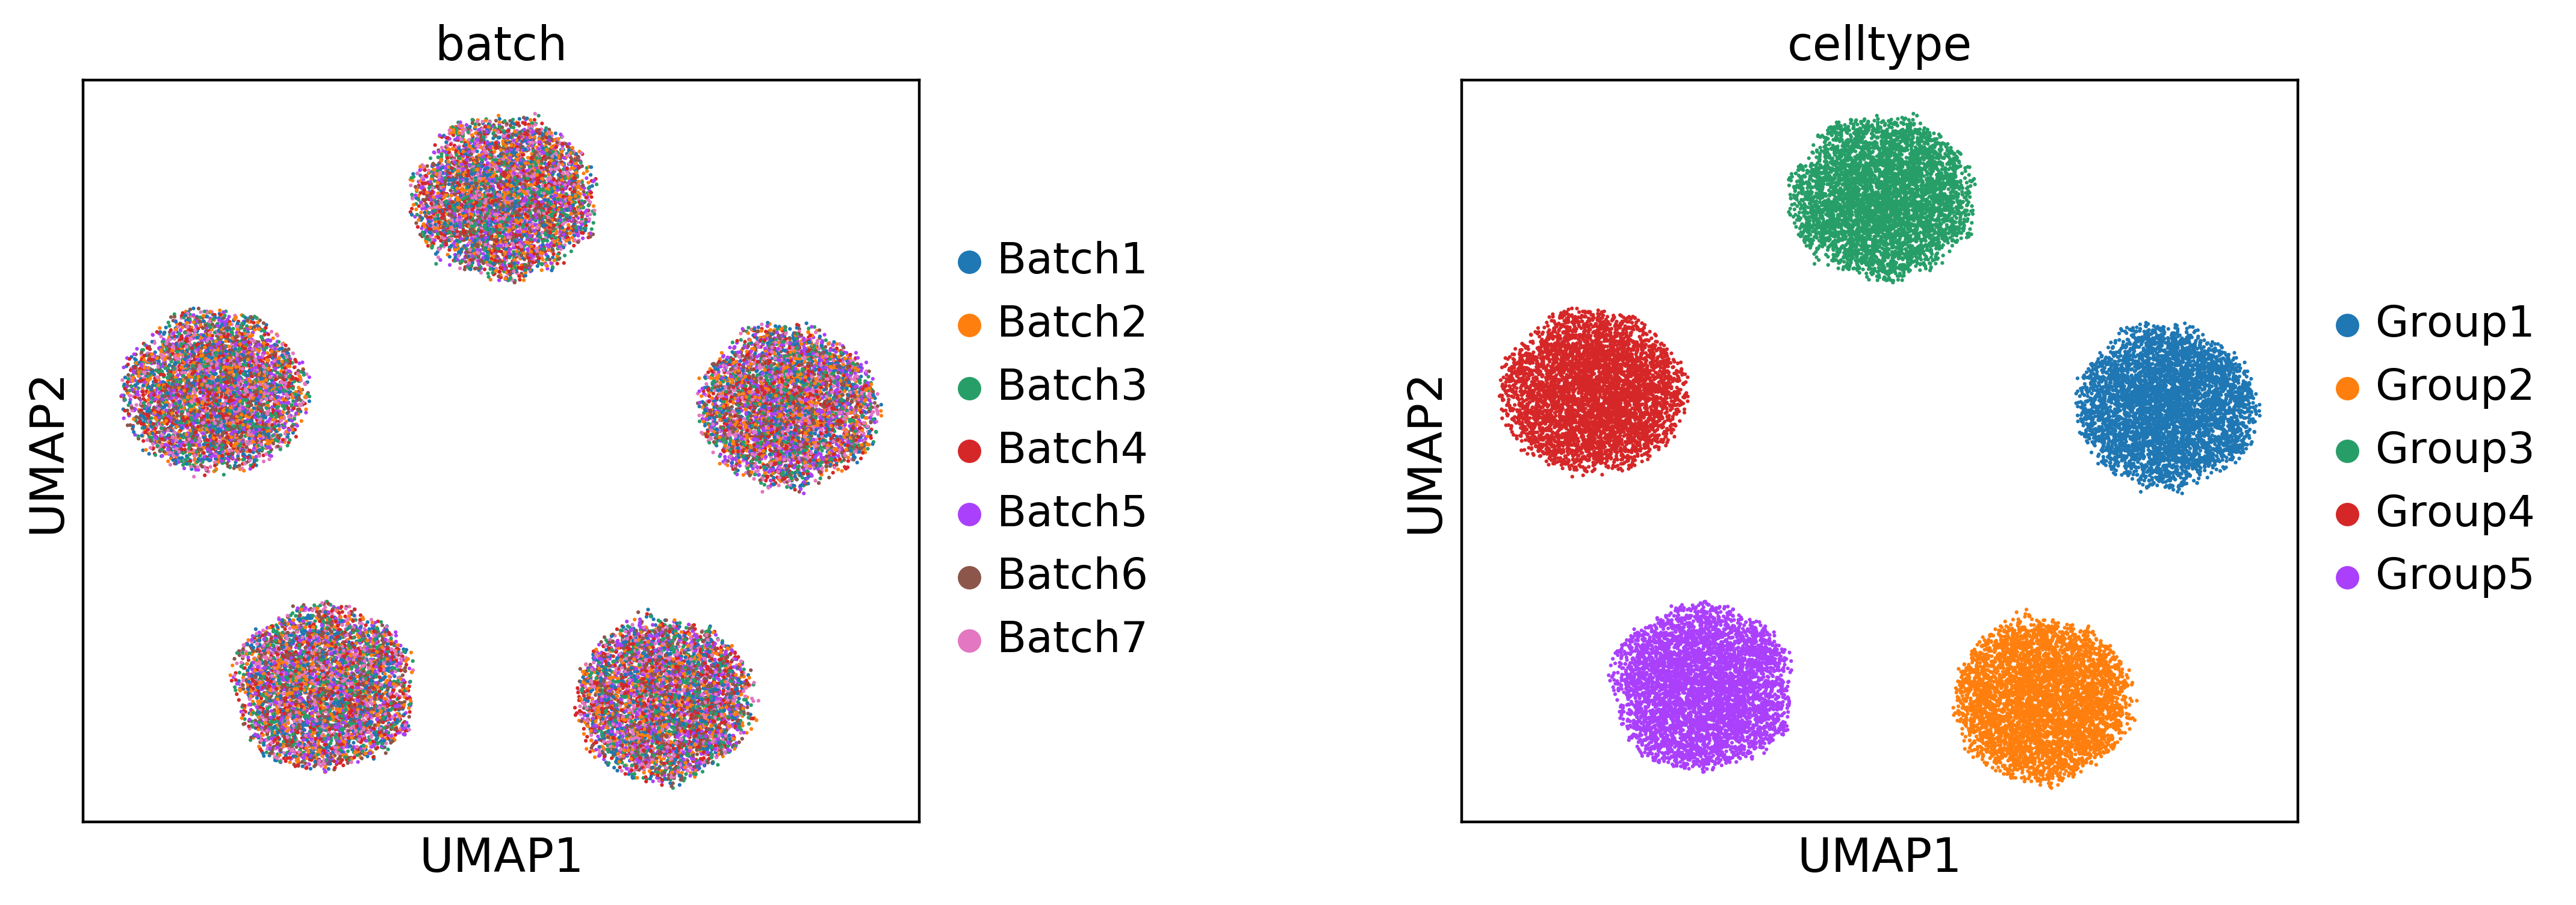

In [25]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [26]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:149: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2009)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1028608     concatenate_3[0][0]              
__________

In [27]:
new_network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6,
 'Batch8': 7,
 'Batch9': 8}

## Train with small new dataset containing out-of-sample condition

In [28]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [29]:
train_adata.shape, valid_adata.shape

((6800, 2000), (1200, 2000))

In [30]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  n_per_epoch=5,
                  score_filename="./results/convergence/toy/scores_scNetFreezed_count.log",
                  save=True, 
                  verbose=2)

Train on 6800 samples, validate on 1200 samples
Epoch 1/100
 - 1s - loss: 8.2861 - nb: 8.2861 - val_loss: 7.9959 - val_nb: 7.9959
Epoch 0: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0484 - ARI: 0.0399 - NMI: 0.0746 - EBM: 0.6825
Epoch 2/100
 - 0s - loss: 8.2514 - nb: 8.2514 - val_loss: 7.8145 - val_nb: 7.8145
Epoch 3/100
 - 0s - loss: 8.2322 - nb: 8.2322 - val_loss: 7.4438 - val_nb: 7.4438
Epoch 4/100
 - 0s - loss: 8.2164 - nb: 8.2164 - val_loss: 6.9542 - val_nb: 6.9542
Epoch 5/100
 - 0s - loss: 8.1936 - nb: 8.1936 - val_loss: 6.5322 - val_nb: 6.5322
Epoch 6/100
 - 0s - loss: 8.1780 - nb: 8.1780 - val_loss: 6.2134 - val_nb: 6.2134
Epoch 5: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0747 - ARI: 0.1096 - NMI: 0.2241 - EBM: 0.6834
Epoch 7/100
 - 0s - loss: 8.1571 - nb: 8.1571 - val_loss: 5.9547 - val_nb: 5.9547
Epoch 8/100
 - 0s - loss: 8.1383 - nb: 8.1383 - val_loss: 5.8487 - val_nb: 5.8487
Epoch 9/100
 - 0s - loss: 8.1237 - nb: 8.1237 - val_loss: 5.8451 - val_nb: 5.8451
Epoch 10/100
 - 0s - loss: 8.1038 - nb: 8.1038 - val_loss: 5.8868 - val_nb: 5.8868
Epoch 11/100
 - 0s - loss: 8.0942 - nb: 8.0942 - val_loss: 5.9796 - val_nb: 5.9796
Epoch 10: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0899 - ARI: 0.0934 - NMI: 0.1370 - EBM: 0.6832
Epoch 12/100
 - 0s - loss: 8.0841 - nb: 8.0841 - val_loss: 6.1780 - val_nb: 6.1780
Epoch 13/100
 - 0s - loss: 8.0722 - nb: 8.0722 - val_loss: 6.4360 - val_nb: 6.4360
Epoch 14/100
 - 0s - loss: 8.0616 - nb: 8.0616 - val_loss: 6.6387 - val_nb: 6.6387
Epoch 15/100
 - 0s - loss: 8.0543 - nb: 8.0543 - val_loss: 6.7645 - val_nb: 6.7645
Epoch 16/100
 - 0s - loss: 8.0455 - nb: 8.0455 - val_loss: 6.9020 - val_nb: 6.9020
Epoch 15: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0989 - ARI: 0.0975 - NMI: 0.2173 - EBM: 0.6836
Epoch 17/100
 - 0s - loss: 8.0411 - nb: 8.0411 - val_loss: 7.0427 - val_nb: 7.0427
Epoch 18/100
 - 0s - loss: 8.0369 - nb: 8.0369 - val_loss: 7.1431 - val_nb: 7.1431
Epoch 19/100
 - 0s - loss: 8.0297 - nb: 8.0297 - val_loss: 7.2466 - val_nb: 7.2466
Epoch 20/100
 - 0s - loss: 8.0257 - nb: 8.0257 - val_loss: 7.3164 - val_nb: 7.3164
Epoch 21/100
 - 0s - loss: 8.0203 - nb: 8.0203 - val_loss: 7.4256 - val_nb: 7.4256
Epoch 20: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0975 - ARI: 0.0820 - NMI: 0.1655 - EBM: 0.6834
Epoch 22/100
 - 0s - loss: 8.0127 - nb: 8.0127 - val_loss: 7.5370 - val_nb: 7.5370
Epoch 23/100
 - 0s - loss: 8.0115 - nb: 8.0115 - val_loss: 7.5833 - val_nb: 7.5833
Epoch 24/100
 - 0s - loss: 8.0070 - nb: 8.0070 - val_loss: 7.6806 - val_nb: 7.6806
Epoch 25/100
 - 0s - loss: 8.0056 - nb: 8.0056 - val_loss: 7.7213 - val_nb: 7.7213
Epoch 26/100
 - 0s - loss: 8.0030 - nb: 8.0030 - val_loss: 7.7858 - val_nb: 7.7858
Epoch 25: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0876 - ARI: 0.0532 - NMI: 0.1290 - EBM: 0.6827
Epoch 27/100
 - 0s - loss: 8.0010 - nb: 8.0010 - val_loss: 7.8081 - val_nb: 7.8081
Epoch 28/100
 - 0s - loss: 7.9987 - nb: 7.9987 - val_loss: 7.8381 - val_nb: 7.8381
Epoch 29/100
 - 0s - loss: 7.9976 - nb: 7.9976 - val_loss: 7.8242 - val_nb: 7.8242
Epoch 30/100
 - 0s - loss: 7.9940 - nb: 7.9940 - val_loss: 7.8701 - val_nb: 7.8701
Epoch 31/100
 - 0s - loss: 7.9933 - nb: 7.9933 - val_loss: 7.8910 - val_nb: 7.8910
Epoch 30: 	

/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


ASW: 0.0808 - ARI: 0.0362 - NMI: 0.0976 - EBM: 0.6835
Epoch 32/100
 - 0s - loss: 7.9934 - nb: 7.9934 - val_loss: 7.9295 - val_nb: 7.9295
Epoch 33/100
 - 0s - loss: 7.9907 - nb: 7.9907 - val_loss: 7.9378 - val_nb: 7.9378
Epoch 34/100
 - 0s - loss: 7.9909 - nb: 7.9909 - val_loss: 7.9475 - val_nb: 7.9475


In [31]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [32]:
adata_out_of_sample.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Name: batch, dtype: int64

In [33]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8000 × 10 
    obs: 'batch', 'celltype', 'n_counts', 'size_factors'

In [34]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

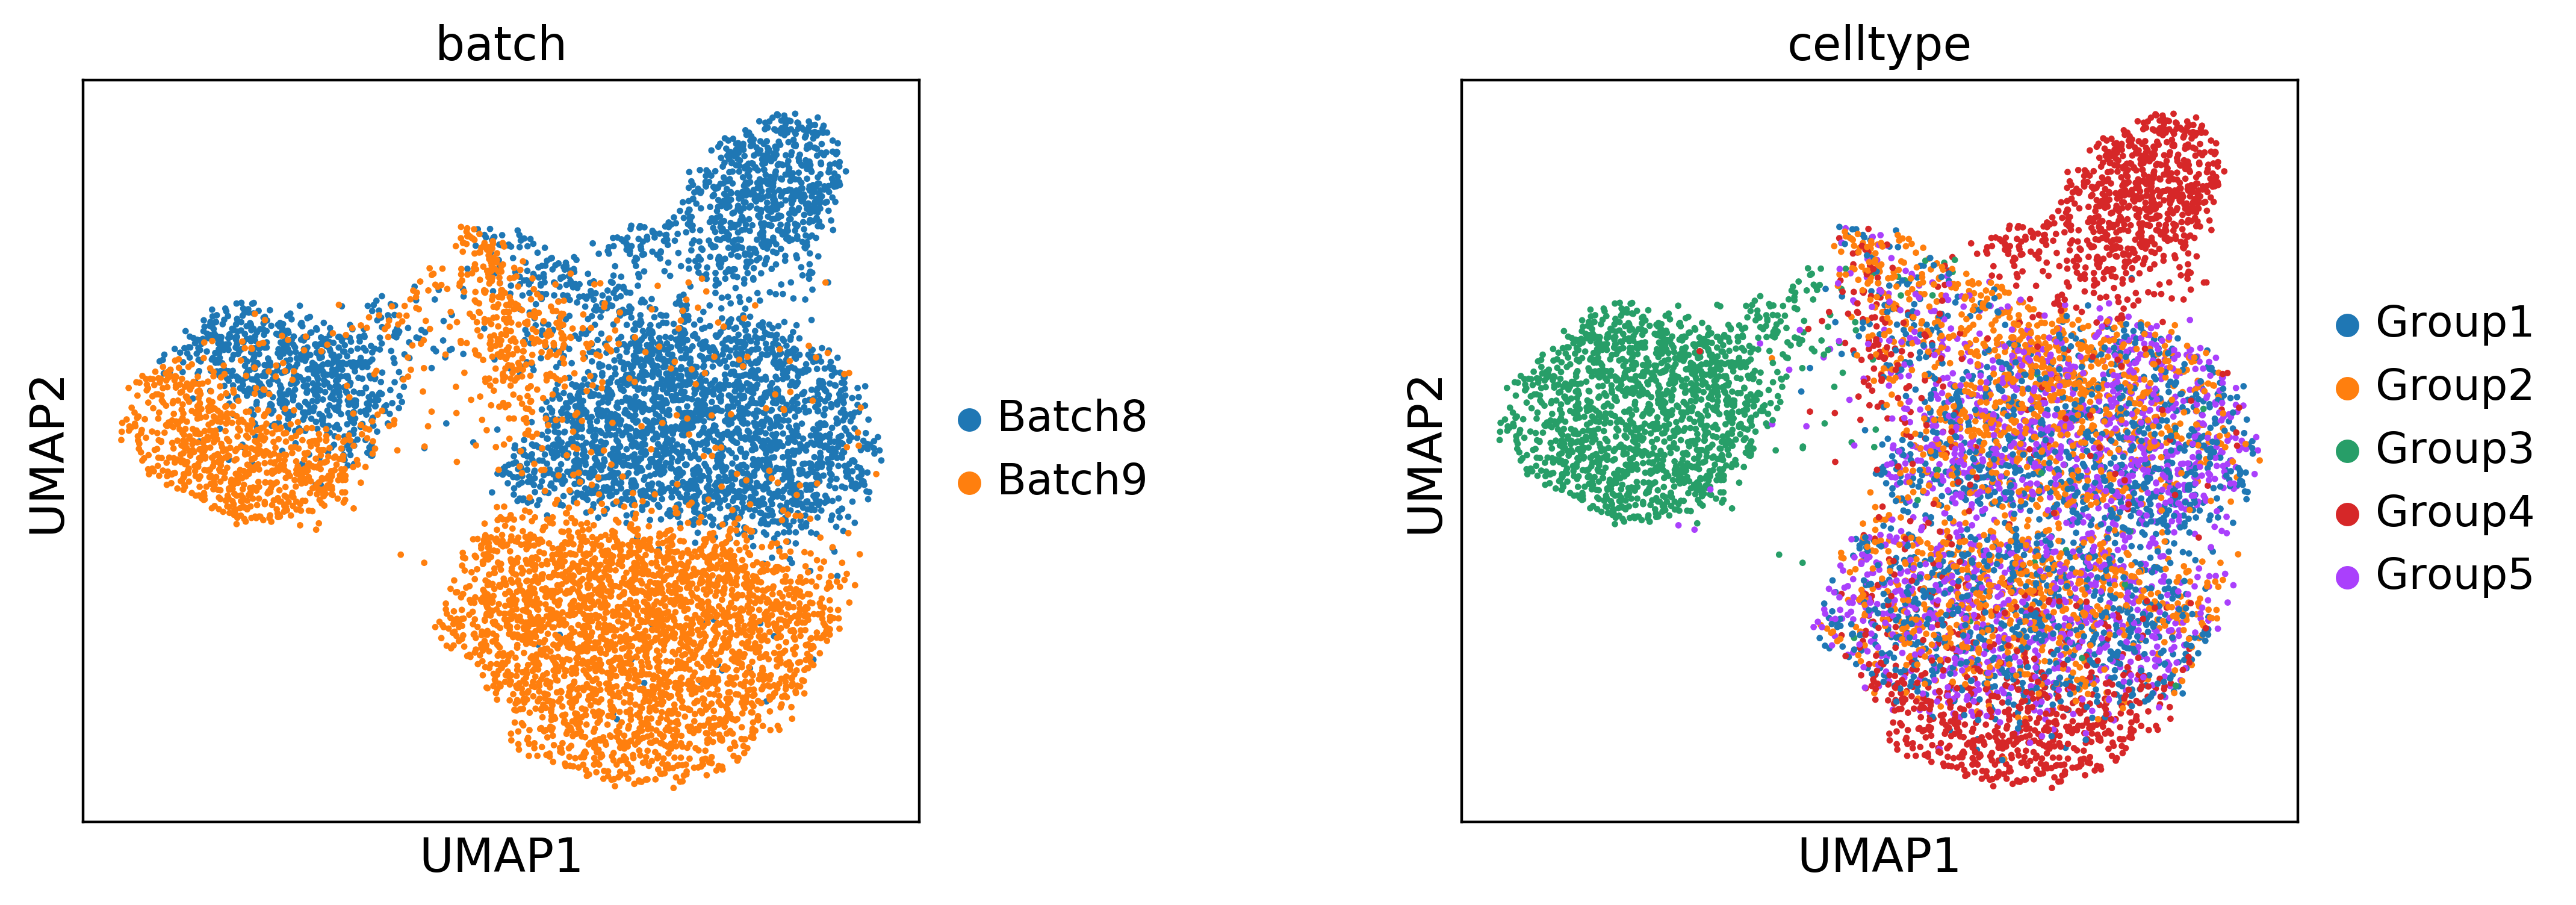

In [35]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)